In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('/Users/john.tung/Downloads/titanic/train.csv')
test_df = pd.read_csv('/Users/john.tung/Downloads/titanic/test.csv')
data_df = train_df.append(test_df)
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Sex,Survived
0,female,0.742
1,male,0.189


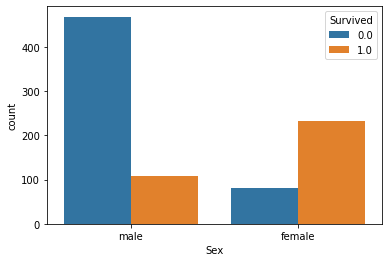

In [3]:
sns.countplot(data_df['Sex'], hue=data_df['Survived'])
data_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().round(3)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


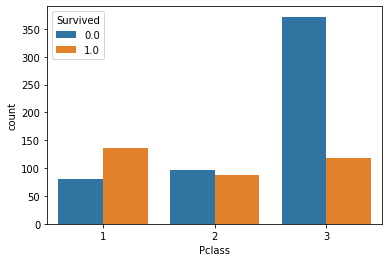

In [4]:
sns.countplot(data_df['Pclass'], hue=data_df['Survived'])
data_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().round(3)

In [5]:
# 將性別資料轉為 0 1，0 為女性，1 為男性
data_df['Sex_Code'] = data_df['Sex'].map({'female':0, 'male':1}).astype('int')
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [6]:
# 分開訓練和測試集
train_df = data_df[:len(train_df)]
test_df = data_df[len(train_df):]

In [8]:
# 生還與否設定為目標 Y，其餘為訓練資料 X
X = train_df.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = train_df['Survived']

In [9]:
# Show Bseline
Base = ['Sex_Code', 'Pclass']
Base_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score: %.5f' %(Base_Model.oob_score_))

Base oob score: 0.73176


In [10]:
test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [16]:
Predict = Base_Model.predict(test_df[Base])
Predict_result = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':Predict}).astype(int)
Predict_result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [17]:
Predict_result.to_csv('submission.csv', index=False)